# Atak zwodniczy na filtr spamu e-mail przy użyciu ART

Ten notatnik demonstruje, jak używać **Adversarial Robustness Toolbox (ART)** do przeprowadzenia ataku adwersarialnego na prosty filtr spamu e-mail.

Będziemy:
1. Ładować zbiór danych `SetFit/enron_spam`.
2. Trenować model regresji logistycznej na cechach TF-IDF.
3. Używać ataku `HopSkipJump` z ART do generowania przykładów adwersarzowych w przestrzeni cech.
4. Oceniać odporność modelu.

In [2]:
# Zainstaluj niezbędne biblioteki, jeśli nie są jeszcze zainstalowane
!pip install adversarial-robustness-toolbox scikit-learn datasets pandas numpy matplotlib


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import HopSkipJump
from art.utils import load_mnist

# Ustaw ziarno losowości dla powtarzalności
np.random.seed(42)

C:\Users\Damian\Documents\GitHub\Engieering Thesis\Adversarial_Attacks\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Załadowanie i przetworzenie danych

Używamy zbioru danych `SetFit/enron_spam`, który zawiera e-maile oznaczone jako spam lub ham (nie-spam).

In [4]:
# Załaduj zbiór danych
dataset = load_dataset("SetFit/enron_spam")
df = pd.DataFrame(dataset['train'])

# Wyświetl kilka pierwszych wierszy
print(df.head())

# Sprawdź rozkład klas
print("\nClass Distribution:")
print(df['label_text'].value_counts())

Repo card metadata block was not found. Setting CardData to empty.


   message_id                                               text  label  \
0       33214  any software just for 15 $ - 99 $ understandin...      1   
1       11929  perspective on ferc regulatory action client c...      0   
2       19784  wanted to try ci 4 lis but thought it was way ...      1   
3        2209  enron / hpl actuals for december 11 , 2000 tec...      0   
4       15880  looking for cheap high - quality software ? ro...      1   

  label_text                                            subject  \
0       spam                  any software just for 15 $ - 99 $   
1        ham  perspective on ferc regulatory action client c...   
2       spam  wanted to try ci 4 lis but thought it was way ...   
3        ham         enron / hpl actuals for december 11 , 2000   
4       spam  looking for cheap high - quality software ? ro...   

                                             message       date  
0  understanding oem software\nlead me not into t... 2005-06-18  
1  19 th , 2 :

In [5]:
# Przygotuj dane
X_text = df['text'].values
y = df['label'].values  # 0 dla ham, 1 dla spam

# Podziel na zbiory treningowe i testowe
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

# Wektoryzuj tekst używając TF-IDF
vectorizer = TfidfVectorizer(max_features=1000) # Ogranicz cechy dla szybkości i wizualizacji
X_train = vectorizer.fit_transform(X_train_text).toarray()
X_test = vectorizer.transform(X_test_text).toarray()

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (25372, 1000)
Test data shape: (6344, 1000)


## 2. Trening docelowego modelu

Trenujemy prosty model regresji logistycznej.

In [6]:
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Oceń na zbiorze testowym
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy on Test Set: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy on Test Set: 0.9790

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3084
           1       0.97      0.99      0.98      3260

    accuracy                           0.98      6344
   macro avg       0.98      0.98      0.98      6344
weighted avg       0.98      0.98      0.98      6344



## 3. Stworzenie klasyfikatora ART

Opakowujemy model Scikit-learn za pomocą `SklearnClassifier` z ART, aby umożliwić ataki.

In [7]:
# Utwórz klasyfikator ART
art_classifier = SklearnClassifier(model=model)

# Zweryfikuj dokładność używając klasyfikatora ART
y_pred_art = np.argmax(art_classifier.predict(X_test), axis=1)
print(f"ART Classifier Accuracy: {accuracy_score(y_test, y_pred_art):.4f}")

ART Classifier Accuracy: 0.9790


## 4. Przeprowadzenie ataku (HopSkipJump)

Używamy ataku **HopSkipJump**, ataku typu black-box, który wymaga jedynie prawdopodobieństw klas wyjściowych. Wygenerujemy przykłady zwodnicze dla podzbioru danych testowych (e-maile spam), aby spróbować ominąć filtr.

In [8]:
# Wybierz podzbiór e-maili spam do ataku (Cel: Spam -> Ham)
target_class = 1 # Spam
attack_indices = np.where(y_test == target_class)[0][:20] # Atakuj pierwsze 20 e-maili spam
X_attack = X_test[attack_indices]
y_attack = y_test[attack_indices]

print(f"Attacking {len(X_attack)} spam emails...")

# Zainicjuj atak HopSkipJump
attack = HopSkipJump(classifier=art_classifier, targeted=False, max_iter=50, max_eval=1000, init_eval=10)

# Wygeneruj przykłady adwersarzowe
X_adv = attack.generate(x=X_attack)

# Oceń atak
y_pred_adv = np.argmax(art_classifier.predict(X_adv), axis=1)
success_rate = np.mean(y_pred_adv != y_attack)

print(f"\nAttack Success Rate: {success_rate * 100:.2f}%")
print(f"Original Predictions: {y_attack}")
print(f"Adversarial Predictions: {y_pred_adv}")

Attacking 20 spam emails...


HopSkipJump: 100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


Attack Success Rate: 100.00%
Original Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Adversarial Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 5. Analiza

Porównajmy oryginalne i adwersarialne wektory cech, aby zobaczyć, jak duże zaburzenie było potrzebne.

Average L2 Perturbation: 0.1486


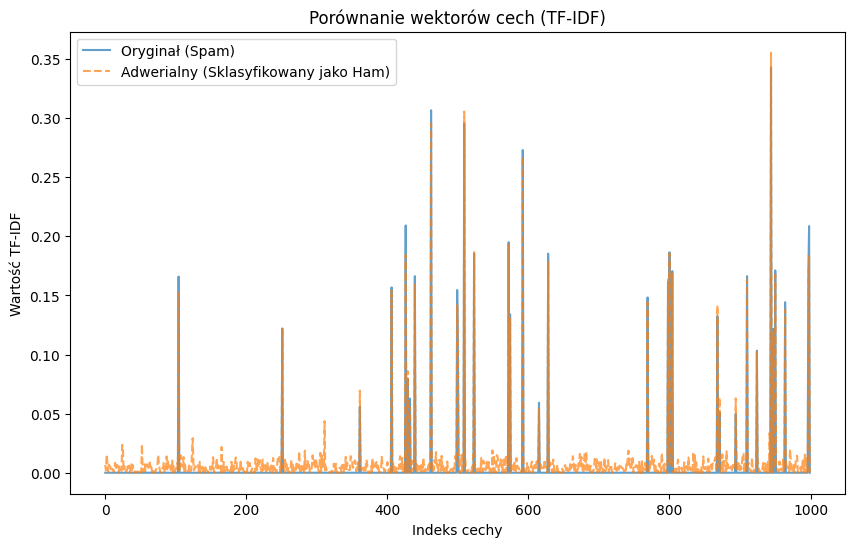

In [10]:
;# Oblicz odległość L2 (wielkość zaburzenia)
perturbations = np.linalg.norm(X_adv - X_attack, axis=1)
avg_perturbation = np.mean(perturbations)

print(f"Average L2 Perturbation: {avg_perturbation:.4f}")

# Wizualizuj zaburzenie dla pierwszego przykładu
plt.figure(figsize=(10, 6))
plt.plot(X_attack[0], label='Oryginał (Spam)', alpha=0.7)
plt.plot(X_adv[0], label='Adwerialny (Sklasyfikowany jako Ham)', alpha=0.7, linestyle='--')
plt.title("Porównanie wektorów cech (TF-IDF)")
plt.xlabel("Indeks cechy")
plt.ylabel("Wartość TF-IDF")
plt.legend()
plt.show()

### Interpretacja wyników

Wykres przedstawia porównanie wektorów cech TF-IDF dla oryginalnej wiadomości spam (linia ciągła) oraz wygenerowanego przykładu adwersarialnego (linia przerywana). Widoczne różnice w wartościach cech na osi Y dla poszczególnych indeksów (oś X) obrazują zaburzenia wprowadzone przez algorytm ataku. Mimo że zmiany te mogą wydawać się niewielkie (co potwierdza niska średnia odległość L2), są one wystarczające, aby zmylić model klasyfikacyjny i spowodować błędną klasyfikację wiadomości jako 'ham' (nie-spam).

### Uwaga dotycząca ataków w przestrzeni cech
Ten atak działa w **przestrzeni cech** (wektory TF-IDF). W rzeczywistym scenariuszu odwzorowanie tych zaburzonych wektorów z powrotem na dyskretny tekst ("problem odwrotny") jest nietrywialne. Jednakże demonstruje to matematyczną podatność modelu na małe zaburzenia w jego przestrzeni wejściowej.